# Produce multiband GeoTIFFs for each Sentinel2 observation, given a shapefile

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | Feb 22, 2019 |
| Last edited: | Feb 25, 2019 |

__Requirements:__

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

This notebook assumes you have cloned the dea-notebooks repository by following the instructions on [DEA notebooks using command line git](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-command-line-git) or [DEA notebooks using Github](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-github). If you didn't, you will need to download any scripts that fail in the first cell into your relative directory so that the notebook will have access to those scripts. `"../"` means the directory above the directory you are working in, and `"./"` means the current directory. 

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Background:__ 

Data from the [Copernicus Sentinel-2] satellite missions (https://sentinel.esa.int/web/sentinel/missions/sentinel-2) are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). 
More information on the Sentinel2 datasets can be found in the [Introduction to Sentinel 2 notebook in dea-notebooks](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/02_DEA_datasets/Introduction_to_Sentinel2.ipynb

__What does this notebook do?:__ 

This notebook uses the`load_clearsentinel2` function to import a time series of cloud-free observations from both Sentinel 2 satellites (i.e. S2A and S2B) as a single combined xarray dataset. It creates an output textfile listing the bands in the GeoTIFF and writes the data for each date to a separate GeoTIFF.

### import modules and scripts

In [2]:
%matplotlib inline

from datacube import Datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting
dc = Datacube(app='Sentinel2')

### set path to polygon here

In [3]:
#change the path here if you want a different polygon
poly_path = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_for_demo.shp'

### plot polygon to check it looks ok

<Figure size 432x288 with 0 Axes>

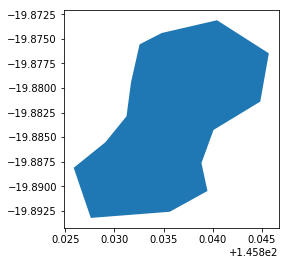

In [4]:
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()
plt.show()

In [5]:
GEOM, SHAPE_NAME = DEADataHandling.open_polygon_from_shapefile(poly_path)

query = {
    'time': ('2016-05-01', '2016-05-30'), 
    'geopolygon': GEOM,
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10)
}

Load cloud free Sentinel data for all sensors (S2A, S2B) for the above query. Setting 
`satellite_metadata=True` will return the data with a variable that gives the abbreviation
of the satellite that made the observation. Masked_prop allows removing timesteps with missing data greater than masked proportion, useful when animating/communicating results.

In [6]:
s2 = DEADataHandling.load_clearsentinel2(dc=dc, query=query, sensors=['s2a', 's2b'],
                                                  bands_of_interest=['fmask', 
                                                                     'nbart_blue', 
                                                                     'nbart_green', 
                                                                     'nbart_red', 
                                                                     'nbart_red_edge_1',
                                                                     'nbart_red_edge_2',
                                                                     'nbart_red_edge_3',
                                                                     'nbart_nir_1',
                                                                     'nbart_nir_2',
                                                                     'nbart_swir_2',
                                                                     'nbart_swir_3'], 
                                                  masked_prop=0, 
                                                  satellite_metadata=True)

Loading s2a pixel quality
    Loading 3 filtered s2a timesteps
Loading s2b pixel quality
    Skipping s2b; no valid data for query
Combining and sorting s2a data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### Print and plot sample of resulting data (false color) 

<Figure size 432x288 with 0 Axes>

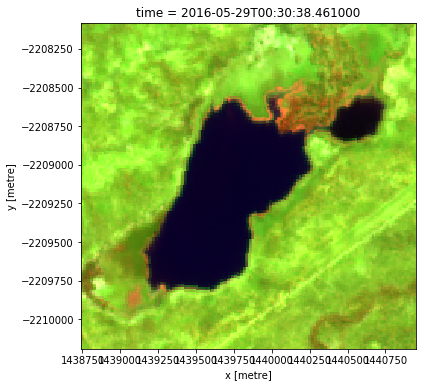

In [7]:
# Plot sample of resulting data for an index (timestep) of your choice
plt.clf()
DEAPlotting.rgb(s2, bands=['nbart_nir_1', 'nbart_swir_2', 'nbart_green'], index=2)

### Set up save file parameters

In [8]:
#get polygon name from the polygon path
polyname = poly_path.split('/')[-1].split('.')[0]

In [9]:
savefilepath = '/g/data/r78/rjd547/WaterCompHackFeb2019/Sentinel2Data/'+polyname

In [10]:
filename=savefilepath

#### The new Sentinel data has multiple data types. GeoTIFFs need only one data type. So we coerce the data to one dtype to write to GeoTIFF.

In [11]:
s2['fmask']=s2['fmask'].astype(np.float64)

### we also drop two information layers that didn't coerce well

In [12]:
s2 = s2.drop(['satellite','data_perc'])

In [13]:
def dataset_to_geotiff2(filename, data):

    """
    this function uses rasterio and numpy to write a multi-band geotiff for one
    timeslice, or for a single composite image. It assumes the input data is an
    xarray dataset (note, dataset not dataarray) and that you have crs and affine
    objects attached, and that you are using float data. future users
    may wish to assert that these assumptions are correct.
    Last modified: Feb 2019
    Authors: Bex Dunn and Josh Sixsmith
    Modified by: Claire Krause, Robbi Bishop-Taylor, Bex Dunn
    inputs
    filename - string containing filename to write out to
    data - dataset to write out
    Note: this function currently requires the data have lat/lon only, i.e. no
    time dimension
    """
    kwargs = {'driver': 'GTiff',
              'count': len(data.data_vars),  # geomedian no time dim
              'width': data.sizes['x'], 'height': data.sizes['y'],
              'crs': data.crs.crs_str,
              'transform': data.affine,
              'dtype': list(data.data_vars.values())[0].values.dtype,
              'nodata': 0,
              'compress': 'deflate', 'zlevel': 4, 'predictor': 2}
    # for ints use 2 for floats use 3}

    with rasterio.open(filename, 'w', **kwargs) as src:
        for i, band in enumerate(data.data_vars):
            src.write(data[band].data, i + 1)

In [14]:
### write the list of bands to a textfile

band_list =[]
with open(filename+'band_list_s2.txt','w') as outfile: 
    for i, band in enumerate(s2.data_vars):
        #print(str(f'{i+1} {band} \n'))
        outfile.write(str(f'{i+1} {band} \n'))
        #band_list.append([i+1,band])
    #print(band_list)    

### Write each date to a separate geotiff

In [15]:
print(filename)

/g/data/r78/rjd547/WaterCompHackFeb2019/Sentinel2Data/reeves_lake_for_demo


In [16]:
#print the dates for which we have imagery and write to file
for i in range(len(s2.time)):
    date_s2 = str(s2.isel(time=i).time.data)[:-19]
    filename2='{}s2_{}.tif'.format(filename,date_s2)
    print(date_s2)
    dataset_to_geotiff2(filename2, s2.isel(time=i))

2016-05-09
2016-05-19
2016-05-29
